<a href="https://colab.research.google.com/github/anggihanafiah-ops/Multimodal-Sentiment-Analysis/blob/main/Copy_of_MultiModal_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install av bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
!pip install -U bitsandbytes

In [ ]:
# import av
import torch
import numpy as np
from transformers import LlavaNextVideoForConditionalGeneration, LlavaNextVideoProcessor, BitsAndBytesConfig

llava_7 ="llava-hf/LLaVA-NeXT-Video-7B-hf"
llava_13 ="llava-hf/LLaVA-NeXT-Video-13B-hf"
pnevision_7="llava-hf/llava-onevision-qwen2-7b-ov-hf"

def next_model(type):
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,  # Mengaktifkan quantization 4-bit
        bnb_4bit_quant_type="nf4",  # Jenis quantization menggunakan NF4
        bnb_4bit_compute_dtype=torch.float16  # Precision komputasi dalam float16
    )
    # Memuat model dengan konfigurasi quantization
    model = LlavaNextVideoForConditionalGeneration.from_pretrained(
        type,
        quantization_config=quantization_config,  # Menggunakan konfigurasi quantization
        device_map="auto"  # Pemetaan otomatis ke GPU/CPU
    )
    processor = LlavaNextVideoProcessor.from_pretrained(type)
    print(f"Model Llava-NEXT {type} berhasil dimuat.")
    return model, processor
def onevision_model(type):
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,  # Mengaktifkan quantization 4-bit
        bnb_4bit_quant_type="nf4",  # Jenis quantization menggunakan NF4
        bnb_4bit_compute_dtype=torch.float16  # Precision komputasi dalam float16
    )
    # Memuat model dengan konfigurasi quantization
    model = LlavaOnevisionForConditionalGeneration.from_pretrained(type, quantization_config=quantization_config, device_map="auto")
    processor = AutoProcessor.from_pretrained(type)
    print(f"Model Llava-onevision {type} berhasil dimuat.")
    return model, processor



SyntaxError: invalid syntax (<ipython-input-3-b83b2fb96f98>, line 16)

In [ ]:
def read_video_pyav(container, indices):
    """
    Decode video frame dengan PyAV.
    Args:
        container: PyAV container untuk video.
        indices: Indeks frame yang akan diambil.
    Returns:
        result: Numpy array frame video (shape: num_frames, height, width, 3).
    """
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


In [ ]:
import av
import numpy as np


def preprocess_video(row):
    formatted_path = f"/content/drive/MyDrive/Multimodal/new/{row['path']}.mp4"
    container = av.open(formatted_path)  # Open video container
    total_frames = container.streams.video[0].frames
    indices = np.linspace(0, total_frames - 1, 10).astype(int)  # Pilih 10 frame dari video

    print(f"Processing video: {row['path']}.mp4")  # Menampilkan nama video yang sedang diproses

    video_tensor = read_video_pyav(container, indices)  # Call read_video_pyav with the container

    for i, idx in enumerate(indices, start=1):
        print(f"Extracting frame {i}/{len(indices)}")  # Menampilkan progres ekstraksi frame

    container.close()  # Close the container after use
    return video_tensor



In [ ]:
def predict_sentiments(model, processor, dataset):
    """Melakukan prediksi sentimen dari dataset yang berisi video dan transkrip."""
    results = []

    for index, row in dataset.iterrows():
        transcript = row["transcript"]
        video_tensor = row["video_tensor"]
        emotion=row["emotion"]

        conversation = [
            {
                "role": "system",
                "content": [
                    {"type": "text", "text": """
                    Anda adalah asisten yang bertugas untuk menentukan sentimen (positif, netral, atau negatif) berdasarkan video, dialog, dan emotion dari karakter pada vidio.
                    Kriteria:
                    1. Sentimen ditentukan berdasarkan video
                    2. Sentimen juga dipengaruhi oleh teks dialog dan emotion karakter dalam video.
                    Berikan respons berupa Positive, Neutral, atau Negative tanpa penjelasan.
                    """},
                ],
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"""
                Dialog dari video:
                "{transcript}"
                Berikut emotion dari karakter dalam video:{emotion}
                """},
                    {"type": "video"},
                ],
            },
        ]

        prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

        inputs = processor(
            text=prompt,
            videos=video_tensor,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        inputs = {key: value.to(model.device) for key, value in inputs.items()}

        output = model.generate(**inputs, max_new_tokens=250)
        result = processor.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        print("Memprediksi Vidio: ",row["path"])
        results.append({"transcript": transcript, "predicted_sentiment": result[0]})

    results_df = pd.DataFrame(results)
    results_df.to_csv("prediksi.csv", index=False)
    return results_df


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

def Read_data(path,cleanKolom=True):
    data=pd.read_csv(path)
    print("\n===========================================================\n")
    print("DATA AWAL : ")
    print("\n===========================================================\n")
    print(data.info())
    if cleanKolom:
        data = data.drop(['Label1',"Label2"], axis=1)
    data= pd.DataFrame(data)
    print("\njumlah data kosong", data.isnull().sum())
    data = data.dropna()

    data['sentiment'] = data['sentiment'].str.lower().str.strip().str.replace(r'\W', '', regex=True)
    mapping = {'negative': 'Negative', 'positive': 'Positive', 'neutral': 'Neutral', 'netral': 'Neutral'}
    data['sentiment'] = data['sentiment'].map(mapping)
    dataclean=data

    sentiment_counts = dataclean['sentiment'].value_counts()

    plt.figure(figsize=(5, 4))
    sns.countplot(x='sentiment', data=dataclean)
    plt.title('Sentiment Label Distribution')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Count')
    print("\n===========================================================\n")
    print("HASIL FUNCTION : ")
    print("\n===========================================================\n")
    print(dataclean.info())
    print("\n===========================================================\n")
    print(sentiment_counts)
    print("\n===========================================================\n")
    plt.show()
    print("\n===========================================================\n")
    print(dataclean)

    return dataclean

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def vidiotensor_predict(dataclean):
    df=dataclean
    df['video_tensor'] = df.apply(preprocess_video, axis=1)
    print("\n===========================================================\n")
    print("\nJumlah Data Tensor kosong: ",df['video_tensor'].isnull().sum())
    print("\n===========================================================\n")
    predictes=predict_sentiments(model, processor, df)

    predictes['predicted_sentiment']=predictes['predicted_sentiment'].str.extract(r'ASSISTANT:\s*(Positive|Neutral|Negative)', expand=False)
    hasil = pd.merge(df, predictes[['transcript', 'predicted_sentiment']], on='transcript', how='left')
    hasil_akhir=hasil[["video_id",	"transcript",	"path",	"emotion",	"sentiment","predicted_sentiment"]]
    print("\nJumlah Data Prediksi kosong yang dihapus: ",hasil_akhir['predicted_sentiment'].isnull().sum())
    hasil_akhir=hasil_akhir.dropna()
    print("\n===========================================================\n")
    print(hasil_akhir.info())
    hasil_akhir.to_csv('hasil_akhir.csv', index=False)
    print("\n===========================================================\n")
    print("\nTabel Akhir :\n",hasil_akhir)

    accuracy = accuracy_score(hasil_akhir["sentiment"], hasil_akhir["predicted_sentiment"])
    print("\n===========================================================\n")
    print(f"Akurasi Model: {accuracy:.2%}")

    print("\nClassification Report:\n")
    print(classification_report(hasil_akhir["sentiment"], hasil_akhir["predicted_sentiment"], target_names=["negative", "neutral", "positive"]))

    cm = confusion_matrix(hasil_akhir["sentiment"], hasil_akhir["predicted_sentiment"], labels=["Negative", "Neutral", "Positive"])
    print("\n===========================================================\n")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return hasil_akhir



DATA AWAL : 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   video_id    240 non-null    object 
 1   transcript  240 non-null    object 
 2   path        240 non-null    object 
 3   Label1      0 non-null      float64
 4   Label2      0 non-null      float64
 5   emotion     155 non-null    object 
 6   sentiment   147 non-null    object 
dtypes: float64(2), object(5)
memory usage: 13.3+ KB
None

jumlah data kosong video_id       0
transcript     0
path           0
emotion       85
sentiment     93
dtype: int64


HASIL FUNCTION : 


<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 0 to 238
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_id    147 non-null    object
 1   transcript  147 non-null    object
 2   path        147 non-null    object
 3   emotion 

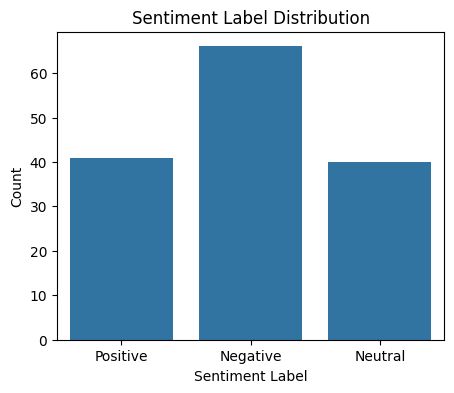



    video_id                                         transcript         path  \
0       1_e3  Aku setuju kamu boleh beli apa aja yang kamu mau.    eps3/1_e3   
1       2_e3                  Pentingan piringnya daripada aku.    eps3/2_e3   
2       3_e3                Mana sih aku pikir ada piring pecah    eps3/3_e3   
3       4_e3                    Kamu gak ngeliat nih aku jatuh.    eps3/4_e3   
4       5_e3                          Ya udah pake yang itu aja    eps3/5_e3   
..       ...                                                ...          ...   
231   232_e3  Yang barang-barang gak penting itu, itu karena...  eps3/232_e3   
234   235_e3                      Udah jual itu aja, kan cukup.  eps3/235_e3   
235   236_e3                          Nggak mungkin itu langka.  eps3/236_e3   
236   237_e3  Itu lebih langka daripada badak bercula satu d...  eps3/237_e3   
238   239_e3                                Ini kok ada disini?  eps3/239_e3   

      emotion sentiment  
0         J

In [ ]:
path="/content/drive/MyDrive/Multimodal/Uji/eps3_20frames.csv"

data=Read_data(path,cleanKolom=True)

In [ ]:
model, processor = model(model7)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model Llava-NEXT llava-hf/LLaVA-NeXT-Video-7B-hf berhasil dimuat.


In [ ]:
akhir=vidiotensor_predict(data)

Processing video: eps3/1_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting frame 10/10
Processing video: eps3/2_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting frame 10/10
Processing video: eps3/3_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting frame 10/10
Processing video: eps3/4_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting 

## 5 Frames settting GPT -- 7B



DATA AWAL : 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   video_id    60 non-null     object 
 1   transcript  60 non-null     object 
 2   path        60 non-null     object 
 3   Label1      0 non-null      float64
 4   Label2      0 non-null      float64
 5   emotion     48 non-null     object 
 6   sentiment   48 non-null     object 
dtypes: float64(2), object(5)
memory usage: 3.4+ KB
None

jumlah data kosong video_id       0
transcript     0
path           0
emotion       12
sentiment     12
dtype: int64


HASIL FUNCTION : 


<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 0 to 59
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_id    48 non-null     object
 1   transcript  48 non-null     object
 2   path        48 non-null     object
 3   emotion     4

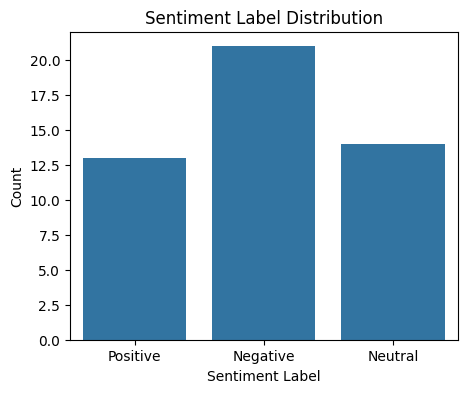



   video_id                                         transcript        path  \
0      1_e3  Aku setuju kamu boleh beli apa aja yang kamu mau.   eps3/1_e3   
1      2_e3                  Pentingan piringnya daripada aku.   eps3/2_e3   
2      3_e3                Mana sih aku pikir ada piring pecah   eps3/3_e3   
3      4_e3                    Kamu gak ngeliat nih aku jatuh.   eps3/4_e3   
4      5_e3                          Ya udah pake yang itu aja   eps3/5_e3   
5      6_e3                                       Terus ini...   eps3/6_e3   
6      7_e3                                      Ya beda dong.   eps3/7_e3   
7      8_e3      Angel, ini kan bangku melukis aku, kamu tahu.   eps3/8_e3   
8      9_e3                      Apa bedanya sama kursi biasa?   eps3/9_e3   
9     10_e3  Feelnya nggak dapet kalau pakai bangku yang lain.  eps3/10_e3   
11    12_e3                             Beli gimana maksudnya?  eps3/12_e3   
12    13_e3           Harganya 5 juta, gajiku kan cuma 3 juta.

In [ ]:
path="/content/drive/MyDrive/Multimodal/Uji/eps3_5frames.csv"

data=Read_data(path,cleanKolom=True)

In [ ]:
model, processor = model(model7)

config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

Model Llava-NEXT llava-hf/LLaVA-NeXT-Video-7B-hf berhasil dimuat.


Processing video: eps3/1_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting frame 10/10
Processing video: eps3/2_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting frame 10/10
Processing video: eps3/3_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting frame 10/10
Processing video: eps3/4_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting 

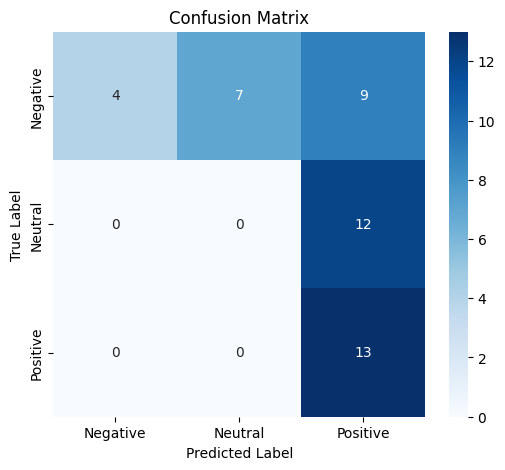

In [ ]:
akhir=vidiotensor_predict(data)

##10 Frames GPT setting -- 7B Model



DATA AWAL : 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   video_id    60 non-null     object 
 1   transcript  60 non-null     object 
 2   path        60 non-null     object 
 3   Label1      0 non-null      float64
 4   Label2      0 non-null      float64
 5   emotion     48 non-null     object 
 6   sentiment   48 non-null     object 
dtypes: float64(2), object(5)
memory usage: 3.4+ KB
None

jumlah data kosong video_id       0
transcript     0
path           0
emotion       12
sentiment     12
dtype: int64


HASIL FUNCTION : 


<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 0 to 59
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_id    48 non-null     object
 1   transcript  48 non-null     object
 2   path        48 non-null     object
 3   emotion     4

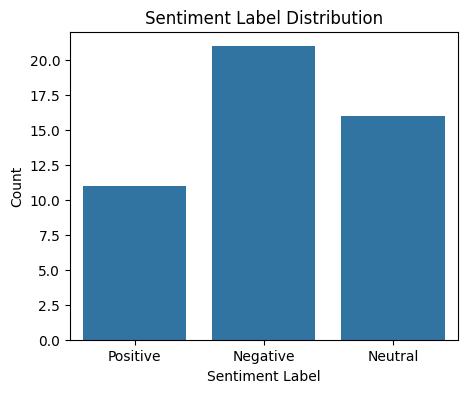



   video_id                                         transcript        path  \
0      1_e3  Aku setuju kamu boleh beli apa aja yang kamu mau.   eps3/1_e3   
1      2_e3                  Pentingan piringnya daripada aku.   eps3/2_e3   
2      3_e3                Mana sih aku pikir ada piring pecah   eps3/3_e3   
3      4_e3                    Kamu gak ngeliat nih aku jatuh.   eps3/4_e3   
4      5_e3                          Ya udah pake yang itu aja   eps3/5_e3   
5      6_e3                                       Terus ini...   eps3/6_e3   
6      7_e3                                      Ya beda dong.   eps3/7_e3   
7      8_e3      Angel, ini kan bangku melukis aku, kamu tahu.   eps3/8_e3   
8      9_e3                      Apa bedanya sama kursi biasa?   eps3/9_e3   
9     10_e3  Feelnya nggak dapet kalau pakai bangku yang lain.  eps3/10_e3   
11    12_e3                             Beli gimana maksudnya?  eps3/12_e3   
12    13_e3           Harganya 5 juta, gajiku kan cuma 3 juta.

In [ ]:
path="/content/drive/MyDrive/Multimodal/Uji/eps3_10frames.csv"

data=Read_data(path,cleanKolom=True)

In [ ]:
model, processor = model(model7)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model Llava-NEXT llava-hf/LLaVA-NeXT-Video-7B-hf berhasil dimuat.


Processing video: eps3/1_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting frame 10/10
Processing video: eps3/2_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting frame 10/10
Processing video: eps3/3_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting frame 10/10
Processing video: eps3/4_e3.mp4
Extracting frame 1/10
Extracting frame 2/10
Extracting frame 3/10
Extracting frame 4/10
Extracting frame 5/10
Extracting frame 6/10
Extracting frame 7/10
Extracting frame 8/10
Extracting frame 9/10
Extracting 

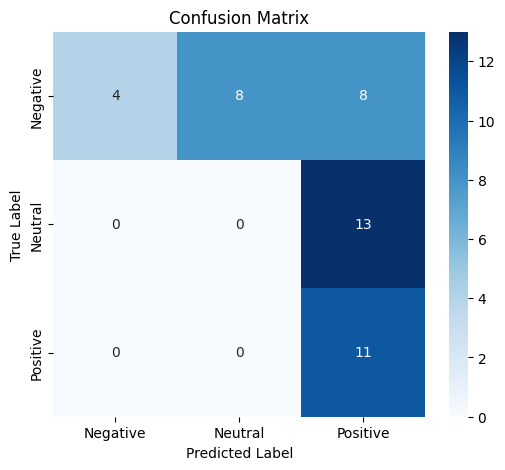

In [ ]:
akhir=vidiotensor_predict(data)

In [ ]:
data

,video_id,transcript,path,emotion,sentiment
1,2_e3,Pentingan piringnya daripada aku.,eps3/2_e3,Anger,Negative
2,3_e3,Mana sih aku pikir ada piring pecah,eps3/3_e3,Surprise,Neutral
3,4_e3,Kamu gak ngeliat nih aku jatuh.,eps3/4_e3,Anger,Negative
4,5_e3,Ya udah pake yang itu aja,eps3/5_e3,Anger,Negative
5,6_e3,Terus ini...,eps3/6_e3,Anger,Negative
6,7_e3,Ya beda dong.,eps3/7_e3,Anger,Negative
7,8_e3,"Angel, ini kan bangku melukis aku, kamu tahu.",eps3/8_e3,Anger,Negative
8,9_e3,Apa bedanya sama kursi biasa?,eps3/9_e3,Anger,Negative
9,10_e3,Feelnya nggak dapet kalau pakai bangku yang lain.,eps3/10_e3,Disgust,Negative
11,12_e3,Beli gimana maksudnya?,eps3/12_e3,Surprise,Neutral


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 1 to 59
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_id    40 non-null     object
 1   transcript  40 non-null     object
 2   path        40 non-null     object
 3   emotion     40 non-null     object
 4   sentiment   40 non-null     object
dtypes: object(5)
memory usage: 1.9+ KB


In [ ]:
akhir.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 47
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   video_id             44 non-null     object
 1   transcript           44 non-null     object
 2   path                 44 non-null     object
 3   emotion              44 non-null     object
 4   sentiment            44 non-null     object
 5   predicted_sentiment  44 non-null     object
dtypes: object(6)
memory usage: 2.4+ KB
